In [ ]:
!pip install --upgrade tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense
from tqdm import trange
import math
import cmath
import time
from scipy import constants

##drawModel1D

In [ ]:
#start = time.clock();
# Please check the Magnetic Permeability (H/m)
# at: https://docs.scipy.org/doc/scipy-0.14.0/reference/constants.html#module-scipy.constants
mu = constants.mu_0; #Magnetic Permeability (H/m)
def drawModel1D(ax, thickness=None, values=None, model=None, depths=None,
                plot='plot',
                xlabel=r'Resistividad $(\Omega$m$)$', zlabel='Profundidad (m)',
                z0=0,
                **kwargs):
    """Draw 1d block model into axis ax.

    Draw 1d block model into axis ax defined by values and thickness vectors
    using plot function.
    For log y cases, z0 should be set > 0 so that the default becomes 1.

    Parameters
    ----------
    ax : mpl axes
        Matplotlib Axes object to plot into.

    values : iterable [float]
        [N] Values for each layer plus lower background.

    thickness : iterable [float]
        [N-1] thickness for each layer. Either thickness or depths must be set.

    depths : iterable [float]
        [N-1] Values for layer depths (positive z-coordinates).
        Either thickness or depths must be set.

    model : iterable [float]
        Shortcut to use default model definition.
        thks = model[0:nLay]
        values = model[nLay:]

    plot : string
        Matplotlib plotting function.
        'plot', 'semilogx', 'semilogy', 'loglog'

    xlabel : str
        Label for x axis.

    ylabel : str
        Label for y axis.

    z0 : float
        Starting depth in m

    **kwargs : dict()
        Forwarded to the plot routine

    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> import numpy as np
    >>> import pygimli as pg
    >>> # plt.style.use('ggplot')
    >>> thk = [1, 4, 4]
    >>> res = np.array([10., 5, 15, 50])
    >>> fig, ax = plt.subplots()
    >>> pg.viewer.mpl.drawModel1D(ax, values=res*5, depths=np.cumsum(thk),
    ...                          plot='semilogx', color='blue')
    >>> pg.viewer.mpl.drawModel1D(ax, values=res, thickness=thk, z0=1,
    ...                          plot='semilogx', color='red')
    >>> pg.wait()
    """
    if model is not None:
        nLayers = (len(model)-1)//2
        thickness = model[:nLayers]
        values = model[nLayers:]

    if thickness is None and depths is None:
        raise Exception("Either thickness or depths must be given.")

    nLayers = len(values)
    px = np.zeros(nLayers * 2)
    pz = np.zeros(nLayers * 2)

    if thickness is not None:
        z1 = np.cumsum(thickness) + z0
    else:
        z1 = depths

    for i in range(nLayers):
        px[2 * i] = values[i]
        px[2 * i + 1] = values[i]

        if i == nLayers - 1:
            pz[2 * i + 1] = z1[i - 1] * 1.2
        else:
            pz[2 * i + 1] = z1[i]
            pz[2 * i + 2] = z1[i]

    if plot == 'loglog' or plot == 'semilogy':
        if z0 == 0:
            pz[0] = z1[0] / 2.
        else:
            pz[0] = z0

    try:
        plot = getattr(ax, plot)
        plot(px, pz+z0, **kwargs)
    except BaseException as e:
        print(e)

    ax.set_ylabel(zlabel)
    ax.set_xlabel(xlabel)
    # assume positive depths pointing upward
    ax.set_ylim(pz[-1], pz[0])
    ax.grid(True)

#Forward VES

In [ ]:
@tf.function
def forward(res):
    res = tf.cast(res, tf.float64)
    ab2 = tf.cast([2, 4, 8, 10, 10, 20, 25, 35, 40, 40, 45, 50, 55, 55, 60, 75, 80, 80, 85, 90, 95], dtype=tf.float64)
    lays = tf.shape(res)[0] - 1
    thk = tf.constant(np.logspace(0.0, 1.0, 8), dtype = tf.float64)
    thick = tf.cast(thk, dtype=tf.float64)

    LOG = tf.math.log(tf.cast(10.0, dtype=tf.float64))
    COUNTER = 1 + (2 * 13 - 2)
    UP = tf.exp(0.5 * LOG / 4.438)

    up = ab2 * tf.exp(-10.0 * LOG / 4.438)
    ti = tf.TensorArray(dtype=tf.float64, size=COUNTER)

    for ii in range(COUNTER):
        ti1 = tf.fill(tf.shape(up), res[lays])

        lay = lays
        while lay > 0:
            lay -= 1
            tan_h = tf.tanh(thick[lay] / up)
            ti1 = (ti1 + res[lay] * tan_h) / (1 + ti1 * tan_h / res[lay])

        ti = ti.write(ii, ti1)
        up *= UP

    ti = ti.stack()

    weights = tf.constant([105, 0, -262, 0, 416, 0, -746, 0, 1605, 0, -4390, 0, 13396, 0, -27841,
                           0, 16448, 0, 8183, 0, 2525, 0, 336, 0, 225], dtype=tf.float64)
    weighted_ti = tf.tensordot(weights, ti, axes=1)
    res_a = weighted_ti / 1e4

    return res_a

In [ ]:
ab2 = tf.cast([2, 4, 8, 10, 10, 20, 25, 35, 40, 40, 45, 50, 55, 55, 60, 75, 80, 80, 85, 90, 95], dtype=tf.float64)
len(ab2)

21

#Forward MT

In [ ]:
@tf.function
def MTforwardModelTF(resistivities):
    frequencies =tf.cast(tf.constant([
    9.09090909e-01, 1.20000000e+00, 1.61000000e+00, 2.17000000e+00, 2.91000000e+00,
    3.90000000e+00, 5.20000000e+00, 7.00000000e+00, 9.40000000e+00, 1.20000000e+01,
    1.50000000e+01, 2.20000000e+01, 3.00000000e+01, 4.00000000e+01, 5.70000000e+01,
    7.40000000e+01, 9.80000000e+01, 1.32000000e+02, 1.76000000e+02, 2.36000000e+02,
    3.18000000e+02, 4.26000000e+02, 5.72000000e+02, 7.66000000e+02, 1.02600000e+03,
    1.37600000e+03, 1.86400000e+03, 2.47400000e+03, 3.31800000e+03, 4.49600000e+03,
    5.99600000e+03
]),dtype=tf.complex128)
    thicknesses =tf.cast(layer_thicknesses_inv,dtype=tf.complex128)
    n = len(resistivities)
    resistivities = tf.cast(resistivities,dtype=tf.complex128)
    #apparentResistivity = tf.TensorArray(dtype=tf.float64, size=0, dynamic_size=True)
    phase = tf.TensorArray(dtype=tf.complex128, size=0, dynamic_size=True)

    for frequency in frequencies:
        w = 2 * math.pi * frequency
        impedances = tf.TensorArray(dtype=tf.complex128, size=n)

        # Compute basement impedance
        impedances = impedances.write(n-1, tf.sqrt(w  *mu*1j * resistivities[n-1]))

        for j in range(n-2, -1, -1):
            resistivity = resistivities[j]
            thickness = thicknesses[j]

            # Compute intrinsic impedance of current layer
            dj = tf.sqrt((w * mu*(1.0/resistivity)) * 1j)
            wj = dj * resistivity

            # Calculate Exponential factor from intrinsic impedance
            ej = tf.exp(-2 * thickness * dj)

            # Calculate reflection coefficient using current layer intrinsic impedance
            # and the below layer impedance
            belowImpedance = impedances.read(j + 1)
            rj = (wj - belowImpedance) / (wj + belowImpedance)
            re = rj * ej
            Zj = wj * ((1 - re) / (1 + re))
            impedances = impedances.write(j, Zj)

        # Compute apparent resistivity from top layer impedance
        Z = impedances.read(0)
        absZ = tf.abs(Z)
        phase = phase.write(phase.size(), Z)

    return phase.stack()

In [ ]:
dz = 8
n_layer = 19
z_factor = 1.42
layer_thicknesses_inv_mt = dz*z_factor**np.arange(n_layer-1)
layer_thicknesses_inv = np.concatenate((np.logspace(0.0, 1.0, 8), layer_thicknesses_inv_mt))

In [ ]:
print(np.sum(np.logspace(0.0, 1.0, 8)))
print(np.sum(layer_thicknesses_inv))
len(layer_thicknesses_inv)

33.106814148093775
10510.230147339924


26

#DLJIneT

In [ ]:
# RED PAUL GOYES
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, concatenate, add

# Function to build the model
def build_model(input_dim_ves, input_dim_mt, output_dim, nc, ly):
    # Define the two input layers: one for the VES data and another for the MT data
    input_layer1 = Input(shape=(input_dim_ves,))  # Input layer for the VES data
    input_layer2 = Input(shape=(input_dim_mt,))   # Input layer for the MT data

    # Concatenate the two input layers into a single layer
    concatenated_inputs = concatenate([input_layer1, input_layer2])

    # First dense layer with ReLU activation
    previous_layer = Dense(nc, activation='relu')(concatenated_inputs)

    # Create hidden layers with residual connections
    for _ in range(ly):
        # Create a dense hidden layer with L1 regularization
        hidden_layer = Dense(nc, activation='relu', kernel_regularizer='l1')(previous_layer)
        # Add the previous layer to the hidden layer (residual connection)
        previous_layer = add([previous_layer, hidden_layer])

    # Output layer with sigmoid activation
    output_layer = Dense(output_dim, activation='sigmoid')(previous_layer)

    # Create the model with the specified inputs and output
    model = keras.Model(inputs=[input_layer1, input_layer2], outputs=output_layer)

    return model

# Define the dimensions of the inputs and output
input_dim_ves = 21  # Dimension of the VES input
input_dim_mt = 31  # Dimension of the MT input
output_dim = 27     # Dimension of the output
nc = 128*2          # Number of neurons in each layer
ly = 2              # Number of hidden layers

# Build the model
DLJIneT = build_model(input_dim_ves, input_dim_mt, output_dim, nc, ly)
#DLJIneT.summary()  # Optional: uncomment this line to print the model summary


#VES data

In [ ]:
d_obs = tf.constant([
    43.025, 65.821, 91.297, 102.94, 108.34, 116.88, 105.47, 73.699,
    86.071, 68.7361, 62.221, 68.475, 72.662, 77.574, 72.827, 74.94,
    81.644, 76.599, 76.703, 83.44, 69.359
], dtype=tf.float64)

synthetic_data_log = tf.cast(tf.math.log(d_obs) / tf.math.log(tf.constant(10.0, dtype=tf.float64)), dtype=tf.float64)

d_obs_scaled = tf.constant(synthetic_data_log, dtype=tf.float64)
d_obs_scaled = tf.reshape(d_obs_scaled, (1, len(synthetic_data_log)))


In [ ]:
d_obs.shape

TensorShape([21])

#MT data

In [ ]:
z_obs = np.array([
   0.11832327+0.08980966j, 0.11884882+0.09727868j, 0.10679374+0.07159674j,
 0.20868367+0.11503598j, 0.12836178+0.06679238j, 0.14205204+0.07419357j,
 0.13653883+0.06366332j, 0.13938673+0.05734143j, 0.15792726+0.06589174j,
 0.13564146+0.06107623j, 0.13102553+0.05567534j, 0.1561272 +0.09209847j,
 0.23443592+0.16400052j, 0.33233969+0.17222836j, 0.24561808+0.178892j,
 0.50514699+0.08734566j, 0.37739557+0.20299921j, 0.55836773+0.19734667j,
 0.66636793+0.19771891j, 0.86535096+0.21638905j, 0.70439298+0.23134702j,
 0.84649194+0.15633344j, 1.3467515 +0.48432352j, 1.22730413+0.16113226j,
 1.47981452+0.44929997j, 1.57902656+0.20241917j, 1.63376543+0.22372667j,
 2.02476658+0.3007556j,  1.42756438+0.4934453j,  1.40863219+0.42448792j,
 1.27804225+0.72259205j])


z_obs_scaled = tf.reshape(z_obs, (1, len(z_obs)))

In [ ]:
print(z_obs_scaled)

tf.Tensor(
[[0.11832327+0.08980966j 0.11884882+0.09727868j 0.10679374+0.07159674j
  0.20868367+0.11503598j 0.12836178+0.06679238j 0.14205204+0.07419357j
  0.13653883+0.06366332j 0.13938673+0.05734143j 0.15792726+0.06589174j
  0.13564146+0.06107623j 0.13102553+0.05567534j 0.1561272 +0.09209847j
  0.23443592+0.16400052j 0.33233969+0.17222836j 0.24561808+0.178892j
  0.50514699+0.08734566j 0.37739557+0.20299921j 0.55836773+0.19734667j
  0.66636793+0.19771891j 0.86535096+0.21638905j 0.70439298+0.23134702j
  0.84649194+0.15633344j 1.3467515 +0.48432352j 1.22730413+0.16113226j
  1.47981452+0.44929997j 1.57902656+0.20241917j 1.63376543+0.22372667j
  2.02476658+0.3007556j  1.42756438+0.4934453j  1.40863219+0.42448792j
  1.27804225+0.72259205j]], shape=(1, 31), dtype=complex128)


#Training algorithm

In [ ]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)
alpha = 0.8

@tf.function
def train():
    with tf.GradientTape() as tape:

        #------VES

        # Cast z_obs to real before passing it to DLJIneT
        model_pred = tf.squeeze(DLJIneT([d_obs_scaled, tf.cast(tf.math.real(z_obs_scaled), dtype=tf.float64)], training=True))

        scaled_model_pred = 10 ** (5 * model_pred)
        d_pred = forward(scaled_model_pred[:8])

        log_d_pred = tf.math.log(d_pred) / tf.math.log(tf.constant(10.0, dtype=tf.float64))

        # Compute the second part of the loss (diff / logspace_tensor)
        diff = tf.math.subtract(model_pred[1:], model_pred[:-1])
        diff = tf.cast(diff, dtype=tf.float64)
        logspace_tensor = tf.constant(layer_thicknesses_inv, dtype=tf.float64)

        loss_diff = tf.norm(diff / logspace_tensor, 2)

        loss_VES = 0.5 * tf.norm(d_obs_scaled - log_d_pred, ord=2)

        #-------MT (PAUL GOYES)
        # Cast z_obs to real before passing it to DLJIneT
        res_pred = 10 ** (5 * DLJIneT([d_obs_scaled, tf.abs(tf.cast(tf.math.real(z_obs_scaled), dtype=tf.float64))], training=True))

        # modelreg = tf.cast(1e-3 * tf.norm(tf.cast(tf.math.log(L2model), tf.float64) - tf.cast(tf.math.log(tf.reshape(res_pred, (-1,))), tf.float64), 2), dtype=tf.float64)
        loss_MT = tf.math.real(0.5 * tf.norm(tf.math.log(z_obs_scaled) - tf.math.log(MTforwardModelTF(tf.reshape(res_pred, (-1,)))), 2))  # + modelreg

        # Total loss
        loss = (alpha) * loss_VES + (1.0 - alpha) * loss_MT + (1.0) * loss_diff

    grads = tape.gradient(loss, DLJIneT.trainable_weights)
    optimizer.apply_gradients(zip(grads, DLJIneT.trainable_weights))

    return loss, loss_MT, loss_VES

In [ ]:
from tqdm import trange
loss = []
loss_MT = []
loss_VES = []
pbar = trange(500)
for i in pbar:
  los = train()
  loss.append(los[0].numpy())
  loss_MT.append(los[1].numpy())
  loss_VES.append(los[2].numpy())
  pbar.set_postfix(LOSS=los[0].numpy(), lOSS_VES=los[2].numpy(), LOSS_MT=los[1].numpy())

100%|██████████| 500/500 [01:15<00:00,  6.61it/s, LOSS=0.306, LOSS_MT=0.827, lOSS_VES=0.102]


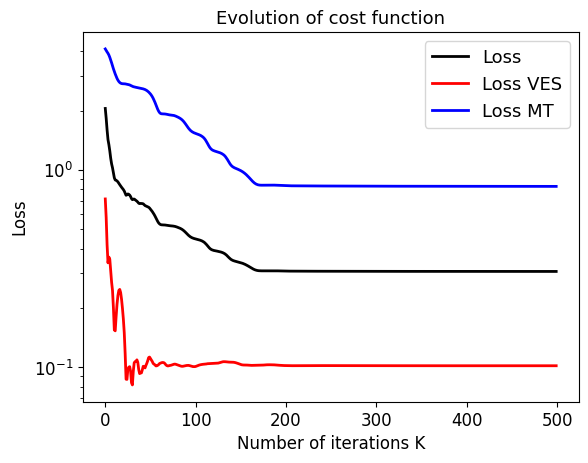

In [ ]:
# Crear el gráfico
plt.plot(loss, label='Loss', color='black', linewidth=2)
plt.plot(loss_VES, label='Loss VES', color='red', linewidth=2)
plt.plot(loss_MT, label='Loss MT', color='blue', linewidth=2)
plt.title('Evolution of cost function', fontsize=13)
plt.xlabel('Number of iterations K', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.yscale('log')
plt.legend(fontsize=13)
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('loss_plot_joint.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

from google.colab import files
#files.download('loss_plot_joint.png')


In [ ]:
model_pred = 10 ** (5 * tf.squeeze(DLJIneT([d_obs_scaled, tf.abs(tf.cast(tf.math.real(z_obs_scaled), dtype=tf.float64))], training=False)))
d_pred_SEV = forward(model_pred[:8])
model_pred_MT = 10 ** (5 * DLJIneT([d_obs_scaled, tf.abs(tf.cast(tf.math.real(z_obs_scaled), dtype=tf.float64))], training=False))
d_pred_MT = MTforwardModelTF(tf.reshape(model_pred_MT, (-1,)))

In [ ]:
print(d_pred_SEV)
print(d_pred_MT)

tf.Tensor(
[ 54.35750661  67.82182844  89.29700201  95.93932904  95.93932904
 100.48156187  94.58308809  82.2375919   77.82827209  77.82827209
  74.81356678  73.00851066  72.16004154  72.16004154  72.02218291
  74.00179669  75.04026911  75.04026911  76.13952706  77.2564177
  78.36232613], shape=(21,), dtype=float64)
tf.Tensor(
[0.10089921+0.05584991j 0.11140824+0.05789669j 0.12261003+0.05965122j
 0.13375735+0.06119112j 0.14420243+0.06282627j 0.15391258+0.06511331j
 0.16268961+0.06868354j 0.17108416+0.07463639j 0.17910689+0.08386164j
 0.18602436+0.09485618j 0.19313632+0.10821593j 0.20934532+0.14008509j
 0.2294804 +0.17519134j 0.25749417+0.21478757j 0.30903792+0.26898013j
 0.36015257+0.30806101j 0.42501435+0.34501061j 0.49956031+0.37770086j
 0.57382847+0.40678649j 0.65395657+0.43857452j 0.74615659+0.47280748j
 0.85084317+0.50096633j 0.96599034+0.51393866j 1.07671596+0.50761354j
 1.17066677+0.48910608j 1.24179583+0.47248754j 1.29306172+0.47272016j
 1.32671709+0.49955358j 1.35449468+0.5626

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


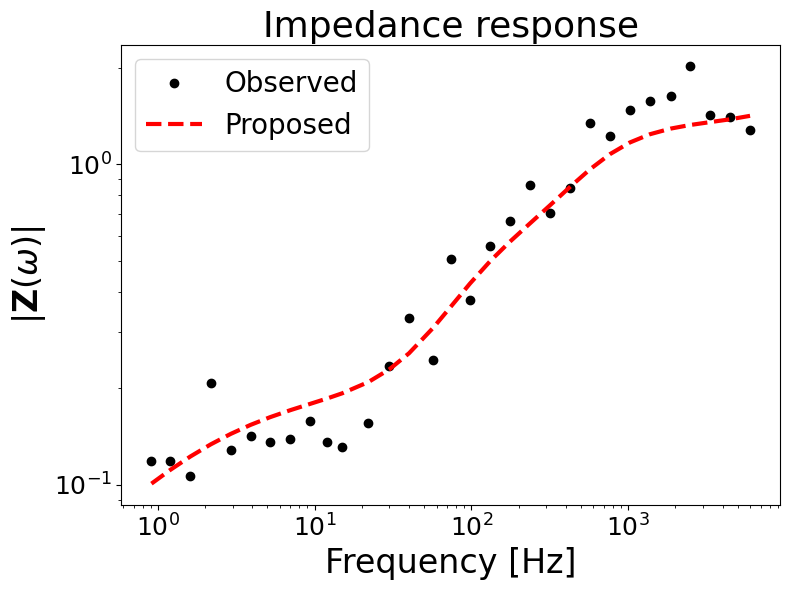

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.loglog(tf.constant([
    9.09090909e-01, 1.20000000e+00, 1.61000000e+00, 2.17000000e+00, 2.91000000e+00,
    3.90000000e+00, 5.20000000e+00, 7.00000000e+00, 9.40000000e+00, 1.20000000e+01,
    1.50000000e+01, 2.20000000e+01, 3.00000000e+01, 4.00000000e+01, 5.70000000e+01,
    7.40000000e+01, 9.80000000e+01, 1.32000000e+02, 1.76000000e+02, 2.36000000e+02,
    3.18000000e+02, 4.26000000e+02, 5.72000000e+02, 7.66000000e+02, 1.02600000e+03,
    1.37600000e+03, 1.86400000e+03, 2.47400000e+03, 3.31800000e+03, 4.49600000e+03,
    5.99600000e+03
], dtype=tf.float32), z_obs,'o', color='black', label='Observed', linewidth=6)
ax.loglog(tf.constant([
    9.09090909e-01, 1.20000000e+00, 1.61000000e+00, 2.17000000e+00, 2.91000000e+00,
    3.90000000e+00, 5.20000000e+00, 7.00000000e+00, 9.40000000e+00, 1.20000000e+01,
    1.50000000e+01, 2.20000000e+01, 3.00000000e+01, 4.00000000e+01, 5.70000000e+01,
    7.40000000e+01, 9.80000000e+01, 1.32000000e+02, 1.76000000e+02, 2.36000000e+02,
    3.18000000e+02, 4.26000000e+02, 5.72000000e+02, 7.66000000e+02, 1.02600000e+03,
    1.37600000e+03, 1.86400000e+03, 2.47400000e+03, 3.31800000e+03, 4.49600000e+03,
    5.99600000e+03
], dtype=tf.float32), d_pred_MT,'--r',label='Proposed',  linewidth=3)

ax.set_ylabel("$|\mathbf{Z}(\omega)|$", fontsize=24)
ax.set_xlabel("Frequency [Hz]", fontsize=24)

ax.tick_params(axis='both', labelsize=18)

plt.title('Impedance response', fontsize=26)

plt.legend(fontsize=20)

plt.tight_layout()
plt.savefig('impedance_response.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
#files.download('impedance_response.eps')

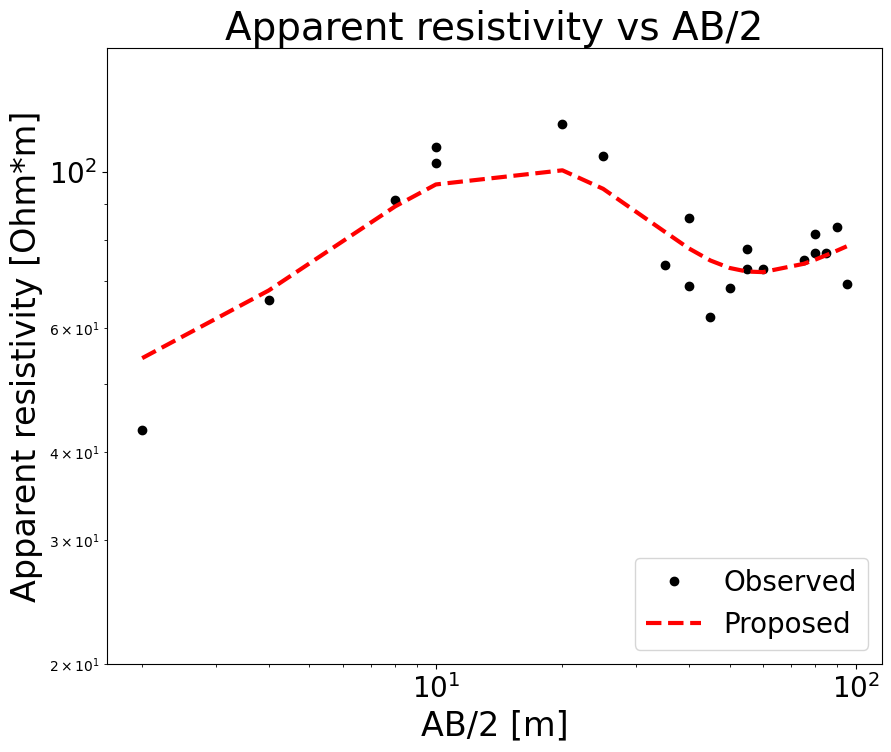

In [ ]:
ab2 = tf.cast([2, 4, 8, 10, 10, 20, 25, 35, 40, 40, 45, 50, 55, 55, 60, 75, 80, 80, 85, 90, 95], dtype=tf.float64)
fig, ax_main = plt.subplots(figsize=(10, 8))

# Observed data
ax_main.plot(ab2, d_obs, 'o', label='Observed', color='black', linewidth=6)

ax_main.plot(ab2, d_pred_SEV, linestyle='dashed', label='Proposed', color='red', linewidth=3)

# Axis settings and title
ax_main.set_ylim(20, 150)
ax_main.set_yscale('log')
ax_main.set_xscale('log')
ax_main.set_xlabel('AB/2 [m]', fontsize=24)
ax_main.set_ylabel('Apparent resistivity [Ohm*m]', fontsize=24)
ax_main.set_title('Apparent resistivity vs AB/2', fontsize=28)
ax_main.tick_params(axis='both', which='major', labelsize=20)
ax_main.legend(fontsize=20, loc='lower right')

# Add grid
ax_main.grid(False)

# Save plot
plt.savefig('apparent_resistivity_vs_ab2.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
# files.download('apparent_resistivity_vs_ab2.png')

#simPEG Inverted Model

In [ ]:
rho_pred = [8.45565659e+02, 1.20124925e+05, 1.23389787e+05, 7.96232195e+04,
       3.45055605e+04, 7.47386753e+02, 1.73680749e+02, 2.72124145e+04,
       1.43971287e+04, 1.81445924e+02, 6.08819172e+03, 2.21823530e+04,
       2.41100764e+04, 1.71484606e+04, 9.97560662e+03, 5.22536438e+03,
       2.60181963e+03, 1.27983714e+03, 6.22079917e+02, 2.88931077e+02,
       1.26292830e+02, 5.28106649e+01, 2.25680859e+01, 1.12793555e+01,
       7.68355176e+00, 7.36215788e+00, 8.69355731e+00, 1.07547523e+01,
       1.26558002e+01, 1.38136888e+01][::-1]

layer_thicknesses_inv_2 = np.concatenate((np.logspace(0.0, 0.8, 11), layer_thicknesses_inv_mt))

#ZondMT1D Model

In [ ]:
rho_ZMT = [38.22, 182.50, 6516.52, 21086.53, 25160.73,5879.48, 209.08, 152935.19, 109226.75, 73.96, 6169.28]
thk_ZMT = [35.0, 12.0, 24.0, 83.0, 320.0, 140.0, 170.0, 1560.0, 750.0, 260.0]

#IPI2WIN Model

In [ ]:
rho_ipi = [31.9, 372, 26.6, 432, 1.78]
thk_ipi = [2, 2.83, 13.6, 14.9]

#pyGIMLi

In [ ]:
rho_pygimli = [30.37787933455128, 87.33691170332243, 283.4055913859256, 327.5820091618624, 125.52794107854258, 39.10158397509237,
               19.26656904666451, 22.830191637241548, 50.898206564891765, 117.66624662938304, 171.40619881217327, 112.88600565279289]

In [ ]:
print(layer_thicknesses_inv)
print(thk_ipi)
print(thk_ZMT)

[1.00000000e+00 1.38949549e+00 1.93069773e+00 2.68269580e+00
 3.72759372e+00 5.17947468e+00 7.19685673e+00 1.00000000e+01
 8.00000000e+00 1.13600000e+01 1.61312000e+01 2.29063040e+01
 3.25269517e+01 4.61882714e+01 6.55873454e+01 9.31340304e+01
 1.32250323e+02 1.87795459e+02 2.66669552e+02 3.78670763e+02
 5.37712484e+02 7.63551727e+02 1.08424345e+03 1.53962570e+03
 2.18626850e+03 3.10450127e+03]
[2, 2.83, 13.6, 14.9]
[35.0, 12.0, 24.0, 83.0, 320.0, 140.0, 170.0, 1560.0, 750.0, 260.0]


/tmp/ipython-input-26-3434063120.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


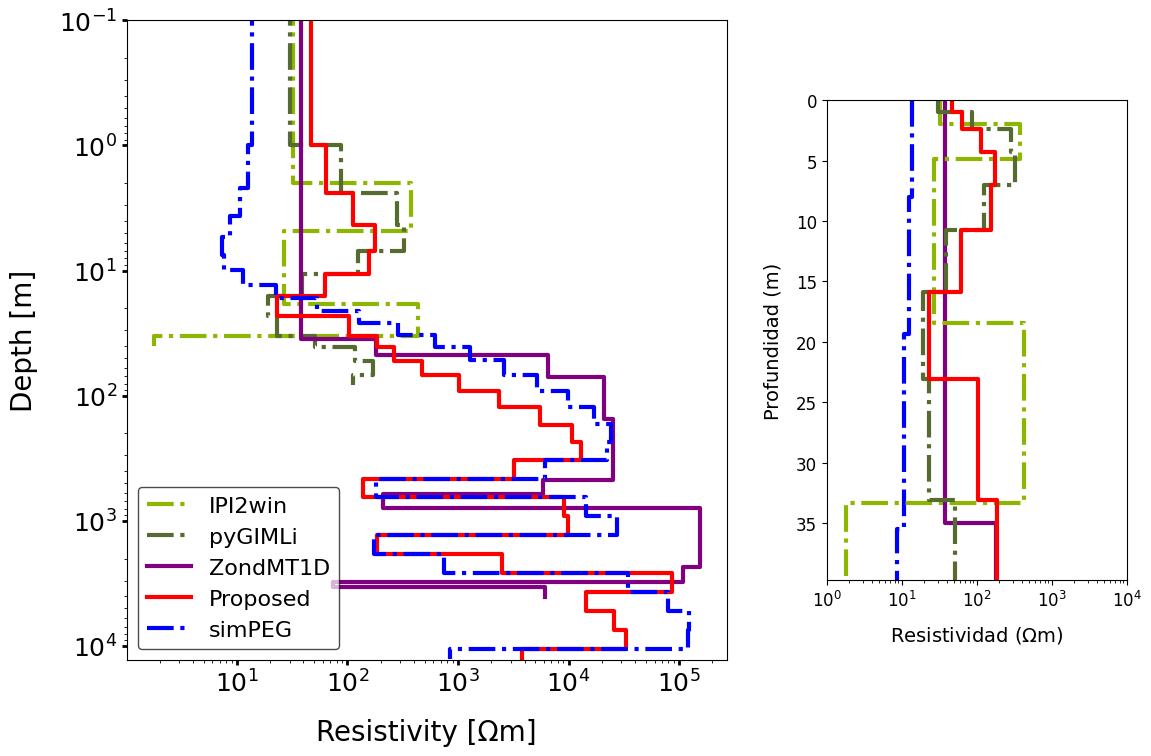

In [ ]:
# Create the figure
fig = plt.figure(figsize=(10, 8))  # Adjusted size to include the zoom outside

# Create the main plot in its fixed position
ax = fig.add_axes([0.08, 0.1, 0.6, 0.8])  # [x, y, width, height] in fractions of the figure

drawModel1D(ax, thk_ipi, rho_ipi, color='#8DB600', linewidth=3.0, label='IPI2win', linestyle='-.')
drawModel1D(ax, layer_thicknesses_inv[:11], rho_pygimli, color='#556B2F', linewidth=3.0, label='pyGIMLi', linestyle='-.')
drawModel1D(ax, thk_ZMT, rho_ZMT, color='purple', label='ZondMT1D', linewidth=3.0)
drawModel1D(ax, layer_thicknesses_inv, model_pred, color='red', label='Proposed', linewidth=3.0)
drawModel1D(ax, layer_thicknesses_inv_2, rho_pred, color='blue', linestyle='-.', label='simPEG', linewidth=3.0)

# Configure the main plot
ax.set_xscale('log')  # Logarithmic scale on the x-axis
ax.set_yscale('log') # # Logarithmic scale on the y-axis
ax.set_xlabel('Resistivity [Ωm]', fontsize=20, labelpad=15)  # X-axis label with extra padding
ax.set_ylabel('Depth [m]', fontsize=20, labelpad=15)  # Y-axis label with extra padding
ax.tick_params(axis='both', which='major', labelsize=18, width=2)  # Increase label size and line thickness
ax.set_ylim(0.1, 13000)
ax.invert_yaxis()

# Create a subplot for the zoom outside the main plot
zoom_ax = fig.add_axes([0.78, 0.2, 0.3, 0.6])  # Adjusted coordinates [x, y, width, height]
zoom_ax.set_xscale('log')  # Logarithmic scale on the x-axis
zoom_ax.set_xlim(20, 1000)  # Limits on the x-axis
zoom_ax.set_ylim(0, 50)  # Limits on the y-axis
zoom_ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust label size
zoom_ax.set_xlabel('Resistivity [Ωm]', fontsize=14, labelpad=10)  # X-axis title in English
zoom_ax.set_ylabel('Depth [m]', fontsize=14, labelpad=10)  # Y-axis title in English

# Draw the same data in the zoom subplot
drawModel1D(zoom_ax, layer_thicknesses_inv_mt[:8], rho_pred[:9], color='blue', linestyle='-.', linewidth=3)  # Blue line
drawModel1D(zoom_ax, thk_ZMT, rho_ZMT, color='purple', linewidth=3)
drawModel1D(zoom_ax, thk_ipi, rho_ipi, color='#8DB600', linewidth=3, linestyle='-.', label='IPI2WIN')
drawModel1D(zoom_ax, layer_thicknesses_inv[:11], rho_pygimli, color='#556B2F', linewidth=3, linestyle='-.', label='pyGIMLi')
drawModel1D(zoom_ax, layer_thicknesses_inv[:8], model_pred[:9], color='red', linewidth=3)  # Red line

# Adjust the legend
ax.legend(fontsize=16, loc='lower left', frameon=True, framealpha=0.7, edgecolor='black', title_fontsize=14)

# Limit values on the x-axis
plt.xlim([1, 10**4])

# Disable grid in both main and zoom axes
ax.grid(False)
zoom_ax.grid(False)  # No grid for the zoom axis

# Improve margins and presentation
plt.tight_layout()

# Save the plot
plt.savefig('inverted_model_real.svg', format='svg', bbox_inches='tight')

# Show the plot
plt.show()

# Code to download the file (if using in an environment like Google Colab)
from google.colab import files
#files.download('inverted_model_real.svg')

In [ ]:

@tf.function
def MTforwardModelTF2(layer_thicknesses_inv,resistivities):
    frequencies =tf.cast(tf.constant([
    9.09090909e-01, 1.20000000e+00, 1.61000000e+00, 2.17000000e+00, 2.91000000e+00,
    3.90000000e+00, 5.20000000e+00, 7.00000000e+00, 9.40000000e+00, 1.20000000e+01,
    1.50000000e+01, 2.20000000e+01, 3.00000000e+01, 4.00000000e+01, 5.70000000e+01,
    7.40000000e+01, 9.80000000e+01, 1.32000000e+02, 1.76000000e+02, 2.36000000e+02,
    3.18000000e+02, 4.26000000e+02, 5.72000000e+02, 7.66000000e+02, 1.02600000e+03,
    1.37600000e+03, 1.86400000e+03, 2.47400000e+03, 3.31800000e+03, 4.49600000e+03,
    5.99600000e+03
]),dtype=tf.complex128)
    thicknesses =tf.cast(layer_thicknesses_inv,dtype=tf.complex128)

    resistivities = tf.cast(resistivities,dtype=tf.complex128)
    n = resistivities.shape[0]
    #apparentResistivity = tf.TensorArray(dtype=tf.float64, size=0, dynamic_size=True)
    phase = tf.TensorArray(dtype=tf.complex128, size=0, dynamic_size=True)

    for frequency in frequencies:
        w = 2 * math.pi * frequency
        impedances = tf.TensorArray(dtype=tf.complex128, size=n)

        # Compute basement impedance
        impedances = impedances.write(n-1, tf.sqrt(w  *mu*1j * resistivities[n-1]))

        for j in range(n-2, -1, -1):
            resistivity = resistivities[j]
            thickness = thicknesses[j]

            # Compute intrinsic impedance of current layer
            dj = tf.sqrt((w * mu*(1.0/resistivity)) * 1j)
            wj = dj * resistivity

            # Calculate Exponential factor from intrinsic impedance
            ej = tf.exp(-2 * thickness * dj)

            # Calculate reflection coefficient using current layer intrinsic impedance
            # and the below layer impedance
            belowImpedance = impedances.read(j + 1)
            rj = (wj - belowImpedance) / (wj + belowImpedance)
            re = rj * ej
            Zj = wj * ((1 - re) / (1 + re))
            impedances = impedances.write(j, Zj)

        # Compute apparent resistivity from top layer impedance
        Z = impedances.read(0)
        absZ = tf.abs(Z)
        phase = phase.write(phase.size(), Z)

    return phase.stack()

In [ ]:
freq = tf.constant([
    9.09090909e-01, 1.20000000e+00, 1.61000000e+00, 2.17000000e+00, 2.91000000e+00,
    3.90000000e+00, 5.20000000e+00, 7.00000000e+00, 9.40000000e+00, 1.20000000e+01,
    1.50000000e+01, 2.20000000e+01, 3.00000000e+01, 4.00000000e+01, 5.70000000e+01,
    7.40000000e+01, 9.80000000e+01, 1.32000000e+02, 1.76000000e+02, 2.36000000e+02,
    3.18000000e+02, 4.26000000e+02, 5.72000000e+02, 7.66000000e+02, 1.02600000e+03,
    1.37600000e+03, 1.86400000e+03, 2.47400000e+03, 3.31800000e+03, 4.49600000e+03,
    5.99600000e+03
], dtype=tf.float32)

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


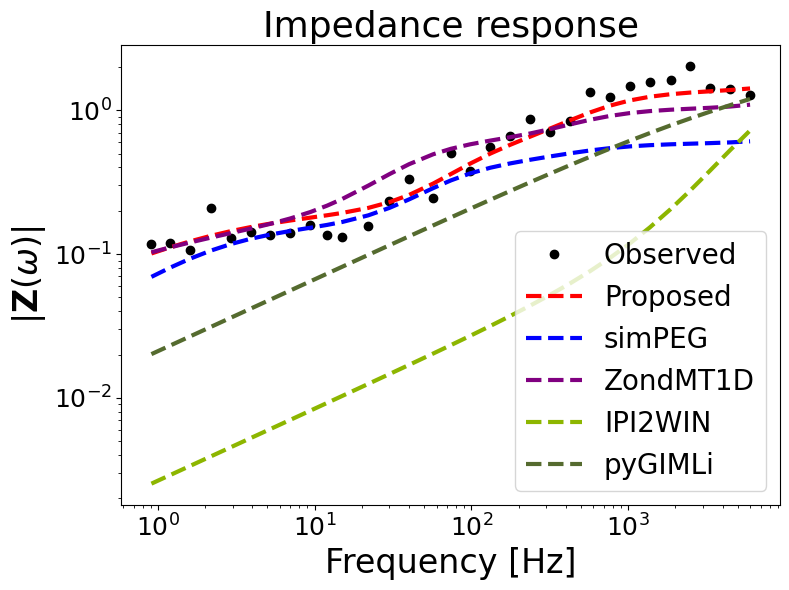

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.loglog(freq, z_obs,'o', color='black', label='Observed', linewidth=6)
ax.loglog(freq, d_pred_MT,'--r',label='Proposed',  linewidth=3)
ax.loglog(freq, MTforwardModelTF2(layer_thicknesses_inv_2,rho_pred),'--',label='simPEG',  linewidth=3, color = 'blue')
ax.loglog(freq, MTforwardModelTF2(thk_ZMT, rho_ZMT),'--',label='ZondMT1D',  linewidth=3, color = 'purple')
ax.loglog(freq, MTforwardModelTF2(thk_ipi, rho_ipi),'--',label='IPI2WIN',  linewidth=3, color = '#8DB600')
ax.loglog(freq, MTforwardModelTF2(np.logspace(0.0, 0.8, 11), rho_pygimli),'--',label='pyGIMLi',  linewidth=3, color = '#556B2F')



ax.set_ylabel("$|\mathbf{Z}(\omega)|$", fontsize=24)
ax.set_xlabel("Frequency [Hz]", fontsize=24)

# Cambiar el tamaño de los números de los ejes
ax.tick_params(axis='both', labelsize=18)

# Cambiar el tamaño del título
plt.title('Impedance response', fontsize=26)

# Cambiar el tamaño de la leyenda
plt.legend(fontsize=20)

plt.tight_layout()
plt.savefig('impedance_response_real.svg', format='svg', bbox_inches='tight')
plt.show()

from google.colab import files
#files.download('impedance_response_real.svg')

In [ ]:
@tf.function
def forward3(res, thk):
    res = tf.cast(res, tf.float64)
    ab2 = tf.cast([2, 4, 8, 10, 10, 20, 25, 35, 40, 40, 45, 50, 55, 55, 60, 75, 80, 80, 85, 90, 95], dtype=tf.float64)
    lays = tf.shape(res)[0] - 1
    thick = tf.cast(thk, dtype=tf.float64)

    LOG = tf.math.log(tf.cast(10.0, dtype=tf.float64))
    COUNTER = 1 + (2 * 13 - 2)
    UP = tf.exp(0.5 * LOG / 4.438)

    up = ab2 * tf.exp(-10.0 * LOG / 4.438)
    ti = tf.TensorArray(dtype=tf.float64, size=COUNTER)

    for ii in range(COUNTER):
        ti1 = tf.fill(tf.shape(up), res[lays])

        lay = lays
        while lay > 0:
            lay -= 1
            tan_h = tf.tanh(thick[lay] / up)
            ti1 = (ti1 + res[lay] * tan_h) / (1 + ti1 * tan_h / res[lay])

        ti = ti.write(ii, ti1)
        up *= UP

    ti = ti.stack()

    weights = tf.constant([105, 0, -262, 0, 416, 0, -746, 0, 1605, 0, -4390, 0, 13396, 0, -27841,
                           0, 16448, 0, 8183, 0, 2525, 0, 336, 0, 225], dtype=tf.float64)
    weighted_ti = tf.tensordot(weights, ti, axes=1)
    res_a = weighted_ti / 1e4

    return res_a

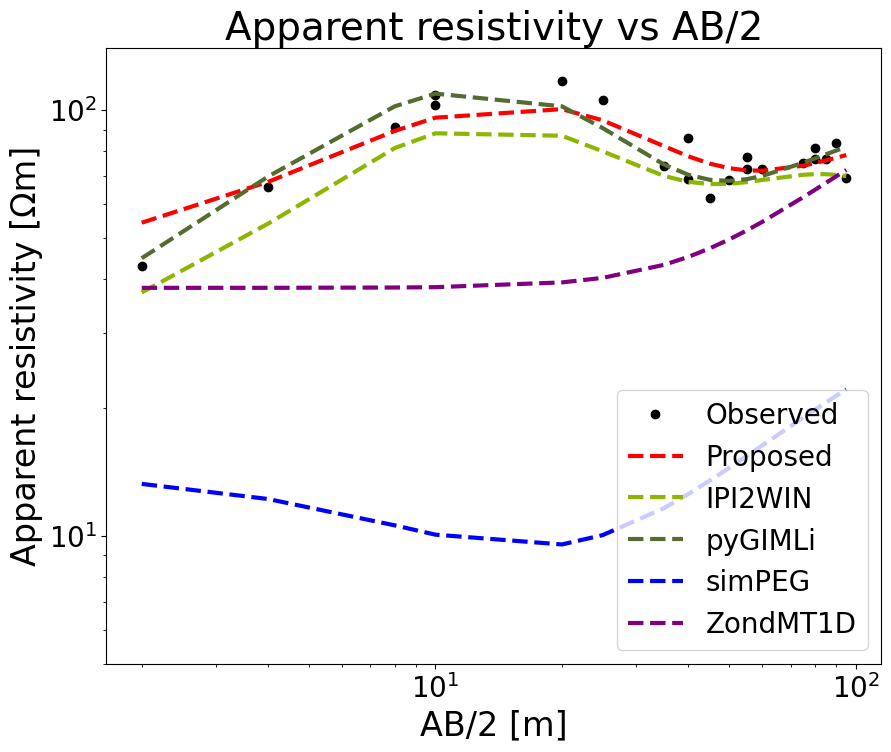

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ab2 = tf.cast([2, 4, 8, 10, 10, 20, 25, 35, 40, 40, 45, 50, 55, 55, 60, 75, 80, 80, 85, 90, 95], dtype=tf.float64)
# Crear el gráfico principal
fig, ax_main = plt.subplots(figsize=(10, 8))

# Datos observados
ax_main.plot(ab2, d_obs, 'o',label='Observed', color='black', linewidth=6)


# Curva ajustada PINNs
ax_main.plot(ab2, d_pred_SEV, linestyle='dashed', label='Proposed', color='red', linewidth=3)
ax_main.plot(ab2, forward3(rho_ipi, thk_ipi), linestyle='dashed',label='IPI2WIN', color='#8DB600', linewidth=3)
ax_main.plot(ab2, forward3(rho_pygimli, np.logspace(0.0, 0.8, 11)), linestyle='dashed',label='pyGIMLi', color='#556B2F', linewidth=3)
ax_main.plot(ab2, forward3(rho_pred[:9], layer_thicknesses_inv[:8]), linestyle='dashed',label='simPEG', color='blue', linewidth=3)
ax_main.plot(ab2, forward3(rho_ZMT[:2], thk_ZMT[:1]), linestyle='dashed',label='ZondMT1D', color='purple', linewidth=3)


# Configuración de ejes y títulos
ax_main.set_ylim(5, 140)
ax_main.set_yscale('log')
ax_main.set_xscale('log')
ax_main.set_xlabel('AB/2 [m]', fontsize=24)
ax_main.set_ylabel('Apparent resistivity [Ωm]', fontsize=24)
ax_main.set_title('Apparent resistivity vs AB/2', fontsize=28)
ax_main.tick_params(axis='both', which='major', labelsize=20)
ax_main.legend(fontsize=20, loc='lower right')

# Añadir cuadrícula
ax_main.grid(False)

# Guardar el gráfico
plt.savefig('apparent_resistivity_vs_ab2_real.svg', format='svg', bbox_inches='tight')
plt.show()

# Código para descargar el archivo (si estás en Google Colab)
from google.colab import files
#files.download('apparent_resistivity_vs_ab2_real.svg')


In [ ]:
def rmspe(observed, predicted, epsilon=1e-3):
    weights = np.abs(observed) / np.mean(np.abs(observed))
    return np.sqrt(np.mean(weights * ((observed - predicted) / (observed + epsilon)) ** 2)) * 100

# Para VES
rmspe_proposed_ves = rmspe(d_obs, d_pred_SEV)
rmspe_ipi2win = rmspe(d_obs, forward3(rho_ipi, thk_ipi))
rmspe_pygimly = rmspe(d_obs, forward3(rho_pygimli, np.logspace(0.0, 0.8, 11)))
rmspe_simpeg = rmspe(d_obs, forward3(rho_pred[:9], layer_thicknesses_inv[:8]))
rmspe_zond1dmt_ves = rmspe(d_obs, forward3(rho_ZMT[:2], thk_ZMT[:1]))

# Para MT
rmspe_proposed_mt = rmspe(np.abs(z_obs), np.abs(d_pred_MT))
rmspe_simpeg_mt = rmspe(np.abs(z_obs), np.abs(MTforwardModelTF2(layer_thicknesses_inv_2, rho_pred)))
rmspe_zond1dmt_mt = rmspe(np.abs(z_obs), np.abs(MTforwardModelTF2(thk_ZMT, rho_ZMT)))
rmspe_pygimly_mt = rmspe(np.abs(z_obs), np.abs(MTforwardModelTF2(np.logspace(0.0, 0.8, 11), rho_pygimli)))
rmspe_ipi2win_mt = rmspe(np.abs(z_obs), np.abs(MTforwardModelTF2(thk_ipi, rho_ipi)))


print(f"RMSPE (VES - Método propuesto): {rmspe_proposed_ves:.2f}%")
print(f"RMSPE (VES - IPI2Win): {rmspe_ipi2win:.2f}%")
print(f"RMSPE (VES - pyGIMLi): {rmspe_pygimly:.2f}%")
print(f"RMSPE (VES - simPEG): {rmspe_simpeg:.2f}%")
print(f"RMSPE (VES - Zond1DMT): {rmspe_zond1dmt_ves:.2f}%")

print(f"RMSPE (MT - Método propuesto): {rmspe_proposed_mt:.2f}%")
print(f"RMSPE (MT - SimPEG): {rmspe_simpeg_mt:.2f}%")
print(f"RMSPE (MT - Zond1DMT): {rmspe_zond1dmt_mt:.2f}%")
print(f"RMSPE (MT - pyGIMLi): {rmspe_pygimly_mt:.2f}%")
print(f"RMSPE (MT - IPI2Win): {rmspe_ipi2win_mt:.2f}%")

RMSPE (VES - Método propuesto): 10.02%
RMSPE (VES - IPI2Win): 14.36%
RMSPE (VES - pyGIMLi): 8.97%
RMSPE (VES - simPEG): 81.86%
RMSPE (VES - Zond1DMT): 42.17%
RMSPE (MT - Método propuesto): 18.46%
RMSPE (MT - SimPEG): 52.95%
RMSPE (MT - Zond1DMT): 34.85%
RMSPE (MT - pyGIMLi): 43.28%
RMSPE (MT - IPI2Win): 72.59%
